In [ ]:
%tensorflow_version 1.x

In [ ]:
from pandas import Series
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import glob
from keras.layers import Dropout
from sklearn.utils import shuffle
import sys
from pandas import DataFrame
import math
from keras.optimizers import Adam
import tensorflow as tf
import os
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
import joblib

In [ ]:
os.chdir('/content/drive/My Drive/New LSTM Crack')

In [ ]:
train_files = glob.glob('./Training/HeatTreated/*.csv')
print('Files in use: {}'.format(len(train_files)))
train_files.sort()
print(train_files)
#train_df = pd.concat([pd.read_csv(f) for f in train_files])
train_df = pd.concat([pd.read_csv(f)[:100000] for f in train_files])

Files in use: 8
['./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv', './Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv', './Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv', './Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv', './Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv', './Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv', './Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv', './Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv']


In [ ]:
# For use in Multivariate Predictions
crack_series = train_df.iloc[:,1].to_numpy().reshape((len(train_df),1))
crack_series = crack_series

In [ ]:
force_series = train_df.iloc[:,2].to_numpy().reshape((len(train_df),1))
temp_series = train_df.iloc[:,3].to_numpy().reshape((len(train_df),1))/900

In [ ]:
stress_intensity = []
specimen_width = 0.0408 #meters #40.8 mm
crossSectArea = 2.6388 #meters

for i in range(len(train_df)):
  term1 = (force_series[i] / crossSectArea) * sqrt(3.14 * crack_series[i])
  term2 = 8.574
  term3 = 10.365 * (crack_series[i] / specimen_width)
  term4 = 5.499 * ((crack_series[i] / specimen_width)**2)
  intensity = term1*(term2 - term3 + term4)
  stress_intensity.append(intensity)
  if i % 100000 == 0:
    print(i)

0
100000
200000
300000
400000
500000
600000
700000


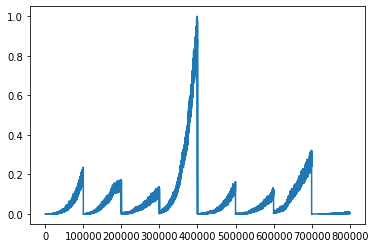

In [ ]:
stress_intensity = np.asarray(stress_intensity).reshape(len(train_df),1)
Scaler = MinMaxScaler()
Scaler.fit(stress_intensity)
joblib.dump(Scaler, './Weights/Scaler_HT.save')
stress_intensity = Scaler.transform(stress_intensity)
plt.plot(stress_intensity)

In [ ]:
series= np.hstack((crack_series, temp_series, stress_intensity))

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
train_size = int(len(series) * 0.9)
test_size = len(series) - train_size
train, test = series[0:train_size], series[train_size:len(series)]

In [ ]:
# choose a number of time steps
n_steps = 3
# split into samples
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 2 # temp stress force

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)

(719997, 3, 2)


In [ ]:
#first = y_train[0]
#y_train_df = pd.DataFrame(y_train)
#assert np.all((y_train_df.diff() == y_train_df - y_train_df.shift())[1:])
#y_train_dl = np.asarray(y_train_df.diff()).flatten()
#y_train_dl[0] = 0

#y_train_df = pd.DataFrame(y_train)
#y_train_d2 = y_train_df.rolling(100).mean().dropna()
#y_train_dl = np.asarray(y_train_d2).flatten()
#X_train = X_train[99:]

#ax = y_train_df.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
#y_train_d2.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)
#ax.legend()

In [ ]:
opt = Adam(learning_rate = 0.0005)
# define model
model = Sequential()
model.add(Bidirectional(LSTM(1000, activation='relu',return_sequences = True, dropout=0.4), input_shape=(n_steps, n_features)))
model.add(Dense(500))
model.add(Bidirectional(LSTM(1000, activation='relu')))
model.add(Dense(1))
model.compile(optimizer=opt, loss='mse')

In [ ]:
# fit model
model.fit(X_train, y_train, epochs=10, verbose=1, batch_size = 500)

Epoch 1/10
719997/719997 [==============================] - 81s 113us/step - loss: 0.0594
Epoch 2/10
719997/719997 [==============================] - 80s 111us/step - loss: 0.0503
Epoch 3/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0447
Epoch 4/10
719997/719997 [==============================] - 80s 110us/step - loss: 0.0430
Epoch 5/10
719997/719997 [==============================] - 80s 111us/step - loss: 0.0413
Epoch 6/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0412
Epoch 7/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0404
Epoch 8/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0404
Epoch 9/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0404
Epoch 10/10
719997/719997 [==============================] - 79s 110us/step - loss: 0.0399


In [ ]:
yhat = model.predict(X_test, verbose=1)

79997/79997 [==============================] - 15s 184us/step


In [ ]:
print(yhat)

[[0.20653927]
 [0.22844481]
 [0.2549448 ]
 ...
 [0.25353265]
 [0.25743493]
 [0.2723183 ]]


In [ ]:
#y_test_df = pd.DataFrame(y_test)
#assert np.all((y_test_df.diff() == y_test_df - y_test_df.shift())[1:])
#y_test_dl = np.asarray(y_test_df.diff()).flatten()
#y_test_dl[0] = 0
#y_test_df = pd.DataFrame(y_test)
#y_test_d2 = y_test_df.rolling(50).mean().dropna()
#y_test_dl = np.asarray(y_test_d2).flatten()
#X_test = X_test[49:]

#ax = y_test_df.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
#y_test_d2.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)
#ax.legend()

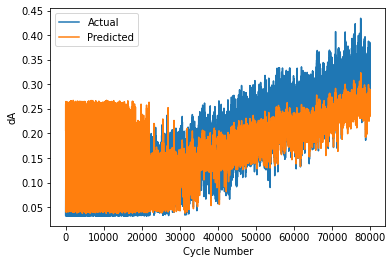

In [ ]:
plt.figure()
plt.plot(y_test, label="Actual")
plt.plot(yhat, label="Predicted")
plt.xlabel("Cycle Number")
plt.ylabel("dA")
plt.legend()
plt.show()


In [ ]:
#mae =  mean_absolute_error(y_test_dl,yhat)
#print(mae)

In [ ]:
model.save("./Weights/Model_HT_3step900Scale100000")